In [7]:
import numpy as np
from tqdm import tqdm
import timeit
from matplotlib import pyplot as plt
from scipy.stats import multivariate_normal
from scipy.stats import bernoulli

from Code import ULA
from Code import Algo1
from Code import ZVnbrosse

In [8]:
def r(theta, x):
    return np.exp(theta.T @ x)/(1+np.exp(theta.T @ x))

def generate_data(p, n):
    X = np.empty((n,p))
    Y = np.empty(n)
    for i in range(n):
        prob = multivariate_normal.rvs(0,1,p)
        X[i, prob < 0] = -1
        X[i, prob >= 0] = +1
        X[i] = X[i]/np.linalg.norm(X[i])
        Y[i] = bernoulli.rvs(r(np.ones(p),X[i].reshape(p,1)))
    return X,Y
def sigma(X):
    n = X.shape[0]
    p = X.shape[1]
    S = np.zeros((p,p))
    for i in range(n):
        S = S + X[i].reshape((p,1)) @ X[i].reshape(1,p)
    return S 

def MLE(X,Y,Sigma):
    n = X.shape[0]
    p = X.shape[1]
    lambda_c = 3*p / np.pi**2
    eps = 1e-6
    mu = np.max(np.linalg.eigvals(Sigma))
    M = (lambda_c + 0.25*n) * mu
    theta_k =[]
    theta_k.append(np.ones((p)))
    theta_k.append(theta_k[0] - 1/(2*M) * f_grad(theta_k[0]))
    i = 2
    while(np.linalg.norm(theta_k[i-1] - theta_k[i-2])**2 > eps**2):
        theta_k.append(theta_k[i-1] - 1/(2*M) * f_grad(theta_k[i-1]))
        i = i+1
    return theta_k[-1]   

def local_weighted_estimator(X):
    return X.sum(axis=1).mean()

def estimator(XX):
    Pi = np.empty(XX.shape[0])
    for i in tqdm(range(XX.shape[0])):
        Pi[i] = local_weighted_estimator(XX[i])
    return Pi

In [23]:
def f_grad(theta):
    n = X_reg.shape[0]
    p = X_reg.shape[1]
    lambda_c = 3*p / np.pi**2
    LOG = np.zeros((p))
    for i in range(n):
        LOG = LOG + X_reg[i].reshape((p)) / (1+np.exp(theta.T @ X_reg[i].reshape((p))))
    F = X_reg.T @ Y_reg - LOG + lambda_c * Sigma @ theta
    return F

In [24]:
dim = 2
h = 0.01
n = 1000
N_train = 50
N_test = 50
n_tilde = 5
deg = 2

np.random.seed(55)
X_reg, Y_reg = generate_data(dim,100)
Sigma = sigma(X_reg)

In [25]:
MLE(X_reg,Y_reg,Sigma).sum()

-0.5910956120580403

In [26]:
# def f_grad(theta):
#     n = X_reg.shape[0]
#     p = X_reg.shape[1]
#     lambda_c = 3*p / np.pi**2
#     tmp = np.exp(X_reg @ theta)
#     LOG = X_reg.T @ np.divide(tmp, 1+tmp)
#     F = X_reg.T @ Y_reg - LOG + lambda_c * Sigma @ theta
#     return F

In [27]:
np.random.seed(2342)
X, G, Z = ULA.ULA_with_burnin(d=dim, step=h, burn_in=10000, n=100000,f_grad=f_grad)

expectation =  -0.5938527534732218


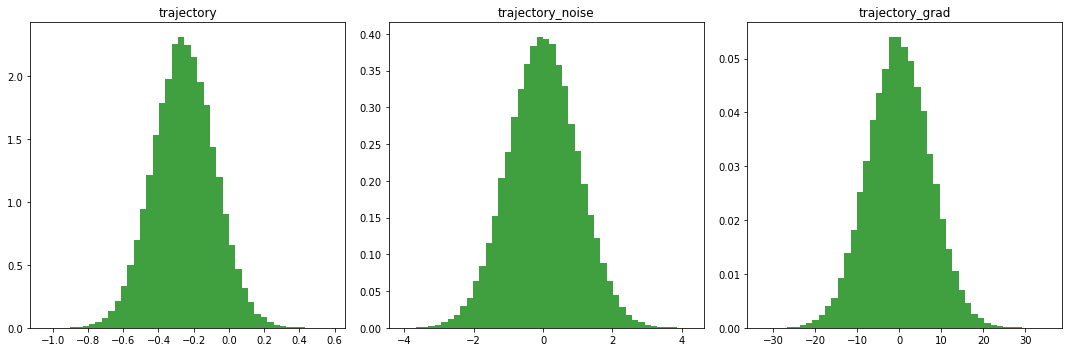

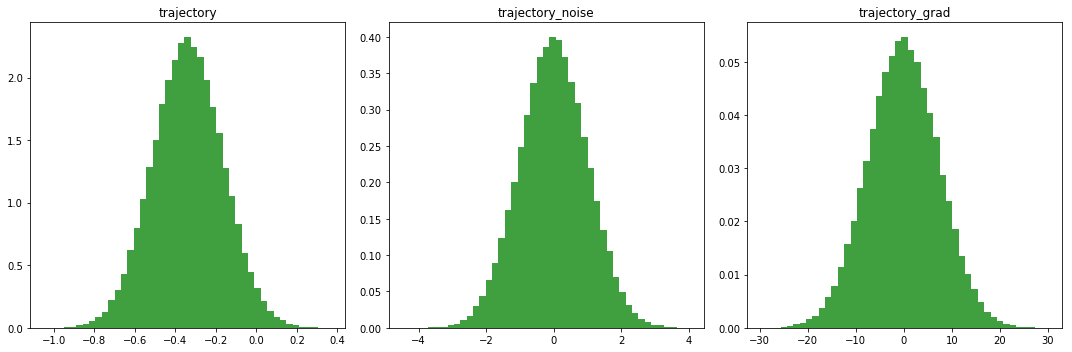

In [28]:
print ('expectation = ',local_weighted_estimator(X))
ULA.plot_distr(X,Z,G,0)
ULA.plot_distr(X,Z,G,1)

In [29]:
np.random.seed(123)

XX, GG, ZZ = ULA.generate_train_trajectories(X, N_train=N_train,d = dim, step = h, n = n, f_grad=f_grad)
XX_test, GG_test, ZZ_test = ULA.generate_test_trajetories(N_test=N_test, d =dim, step=h, 
                                                          burn_in=10000, n = n, f_grad=f_grad)

In [30]:
Betas, degrees = Algo1.G_pml_fit_meansum(XX,max_deg = deg)

100%|██████████| 1000/1000 [00:12<00:00, 82.59it/s]


In [31]:
# k_comb = np.zeros((dim,dim), dtype=np.int16)
# for i in range(dim):
#     k_comb[i,i] = 1

k_comb = np.array([[1,0], [0,1], [1,1], [2,0], [0,2]], dtype=np.int16)

In [32]:
time_1 = timeit.default_timer()
p = local_weighted_estimator(XX_test[-1])
print ("mean of target function =", p)
for i in range(len(k_comb)):
    p = p - Algo1.M_bias(k_comb[i],XX_test[-1],GG_test[-1], ZZ_test[-1], h, degrees,Betas, n_tilde)
    print ("            (k = {}) = {} [Time:{}]".format(k_comb[i],p,timeit.default_timer()-time_1))

mean of target function = -0.5890841338221576
            (k = [1 0]) = -0.5805005732469192 [Time:2.174273637996521]
            (k = [0 1]) = -0.5918980429909466 [Time:4.300053790000675]
            (k = [1 1]) = -0.5918353597068223 [Time:6.100885476000258]
            (k = [2 0]) = -0.5920185417207232 [Time:9.85388205399795]
            (k = [0 2]) = -0.5920557654568318 [Time:13.65435997199529]


In [ ]:
P_test = estimator(XX_test)

M_test = np.empty((len(k_comb),P_test.shape[0]))
for i in range(len(k_comb)):
    M_test[i] = Algo1.estimator_bias(k_comb[i], XX_test, GG_test, ZZ_test, h, degrees,Betas, n_tilde, n_jobs=2)

100%|██████████| 50/50 [00:00<00:00, 14187.20it/s]


In [ ]:
res_zv_1 = []
for i in range (XX_test.shape[0]):
    res_zv_1.append(ZVnbrosse.ZVpolyOne(XX_test[i].reshape(-1,dim), GG_test[i].reshape(-1,dim)))
res_zv_1 = np.array(res_zv_1).reshape(-1)

res_zv_2 = []
for i in range (XX_test.shape[0]):
    res_zv_2.append(ZVnbrosse.ZVpolyTwo(XX_test[i].reshape(-1,dim), GG_test[i].reshape(-1,dim)))
res_zv_2 = np.array(res_zv_2).reshape(-1)

res_cv_1 = []
for i in range (XX_test.shape[0]):
    res_cv_1.append(ZVnbrosse.CVpolyOne(XX_test[i].reshape(-1,dim), GG_test[i].reshape(-1,dim)))
res_cv_1 = np.array(res_cv_1).reshape(-1)

res_cv_2 = []
for i in range (XX_test.shape[0]):
    res_cv_2.append(ZVnbrosse.CVpolyTwo(XX_test[i].reshape(-1,dim), GG_test[i].reshape(-1,dim)))
res_cv_2 = np.array(res_cv_2).reshape(-1)

In [ ]:
plt.figure(figsize=(10,10))
plt.hist(P_test,15, facecolor='r', density=True, alpha=1, label=r"$\pi$")

plt.hist((P_test-M_test.sum(axis=0)),15, density=True, facecolor='g', alpha=0.7, label="Distribution of $\pi - M^2_N$")

# plt.hist(res_zv_1,15, facecolor='y', density=True, alpha=0.8, label="ZV 1")
# plt.hist(res_zv_2,15, facecolor='b', density=True, alpha=0.8, label="ZV 2")
# plt.hist(res_cv_1,15, facecolor='pink', density=True, alpha=0.8, label="CV 1")
# plt.hist(res_cv_2,15, facecolor='black', density=True, alpha=0.8, label="CV 2")

plt.legend(loc=2, prop={'size': 17})
plt.grid(linestyle='-', linewidth=0.2, color='black')
plt.tick_params(axis='y',color = 'w', labelcolor = 'w', which='both')
# plt.xlim(-1.339, -1.338)
plt.show()

In [ ]:
all_data = [P_test]
all_data.append(P_test - M_test.sum(axis = 0))
all_data.append(res_zv_1)
all_data.append(res_zv_2)
all_data.append(res_cv_1)
all_data.append(res_cv_2)
    
plt.figure(figsize=(10,10))
plt.violinplot(all_data, showmeans=True, showmedians=False)
plt.title('violin plot')
plt.xticks(np.arange(1,7), ('pi', 'CV_B', 'ZV_1', 'ZV_2', 'CV_1', 'CV_2'))
plt.grid()
plt.show()

In [ ]:
print ('          Variance of Pi = ',P_test.var(ddof = 1))
for i in range(len(k_comb)):
    print ('Variance of new estimator =',(P_test-M_test[:i+1].sum(axis = 0)).var(ddof = 1))
print ('        Variance of CV 1 = ',res_cv_1.var(ddof=1))
print ('        Variance of CV 2 = ',res_cv_2.var(ddof=1))
print ('        Variance of ZV 1 = ',res_zv_1.var(ddof=1))
print ('        Variance of ZV 2 = ',res_zv_2.var(ddof=1))

In [ ]:
print ('VRF CVB = ',P_test.var(ddof = 1)/ (P_test - M_test.sum(axis = 0)).var(ddof=1))
print ('VRF CV1 = ',P_test.var(ddof = 1)/res_cv_1.var(ddof = 1))
print ('VRF CV2 = ',P_test.var(ddof = 1)/res_cv_2.var(ddof = 1))
print ('VRF ZV1 = ',P_test.var(ddof = 1)/res_zv_1.var(ddof = 1))
print ('VRF ZV2 = ',P_test.var(ddof = 1)/res_zv_2.var(ddof = 1))

In [ ]:
np.save("logs/BLR_2d_M_test_(K = {}, n_tilde={}).npy".format(deg, n_tilde), M_test)